In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import pickle

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MPhosa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MPhosa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [130]:
# Load the dataset
df = pd.read_csv('Data 2.csv')
df

,ID,Test Scenario,Test Cases,Expected Result,Execution #1
0,1,User Registration,Navigate to registration page. Fill in valid d...,User is registered successfully.,Fail
1,2,User Registration,Navigate to registration page. Fill in existin...,Error message for email already in use.,Pass
2,3,User Registration,Navigate to registration page. Leave required ...,Error messages for required fields.,Fail
3,4,User Login,Navigate to login page. Enter valid credential...,User is redirected to homepage.,Pass
4,5,User Login,Navigate to login page. Enter invalid credenti...,Error message indicating invalid credentials.,Fail
...,...,...,...,...,...
1995,1996,Contact Us Form,Fill in the contact form with missing required...,Error messages for required fields.,Fail
1996,1997,System Notifications,Perform actions that trigger notifications.,Notifications are displayed correctly.,Pass
1997,1998,Session Management,Log in and out multiple times.,Session is managed correctly without issues.,Pass
1998,1999,Currency Conversion,Change the currency on the site. Check product...,Prices are displayed in the selected currency.,Pass


In [131]:
# Get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               2000 non-null   int64 
 1   Test Scenario    2000 non-null   object
 2   Test Cases       2000 non-null   object
 3   Expected Result  2000 non-null   object
 4   Execution #1     2000 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [132]:
# Check for missing values
print(df.isnull().sum())

ID                 0
Test Scenario      0
Test Cases         0
Expected Result    0
Execution #1       0
dtype: int64


In [133]:
# Check for duplicates
df.duplicated().sum()

0

In [134]:
# Count the occurrences of each value in 'Status' column
df['Execution #1'].value_counts()

Execution #1
Pass    1080
Fail     920
Name: count, dtype: int64

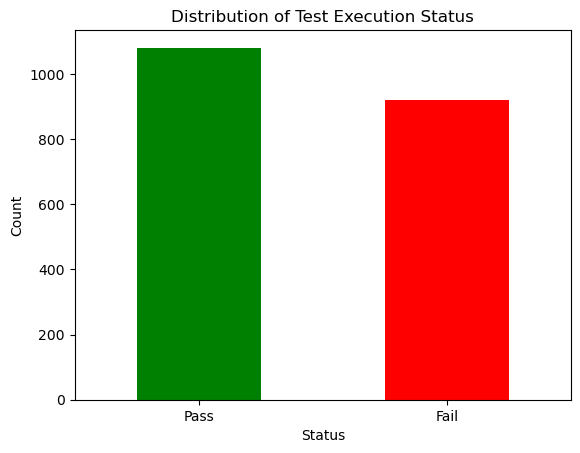

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the distribution with Pass in green and Fail in red
status_counts = df['Execution #1'].value_counts()
colors = ['green' if label == 'Pass' else 'red' for label in status_counts.index]

status_counts.plot(kind='bar', color=colors)

plt.title('Distribution of Test Execution Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Pass', 'Fail'], rotation=0)
plt.show()


In [137]:
# Group by 'Test Scenario' and get the count of passes and fails
print(df.groupby('Test Scenario')['Execution #1'].value_counts())

Test Scenario              Execution #1
Add Product to Cart        Pass            40
Address Management         Pass            80
Advanced Search            Pass            40
Checkout                   Fail            80
Contact Us Form            Fail            80
Currency Conversion        Pass            40
FAQ Page Access            Fail            40
Mobile Responsiveness      Fail            40
Multi-Language Support     Fail            40
Newsletter Subscription    Pass            40
Newsletter Unsubscription  Fail            40
Order Cancellation         Fail            40
Order History              Fail            40
Password Reset             Fail            40
                           Pass            40
Payment Processing         Fail            40
                           Pass            40
Privacy Policy             Pass            40
Product Filtering          Pass            40
Product Review             Pass            80
Product Search             Fail         

In [138]:
df = df.replace({'Execution #1': {'Fail' : 0, 'Pass' : 1}})
df.head(3)

C:\Users\MPhosa\AppData\Local\Temp\ipykernel_11548\4125058209.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Execution #1': {'Fail' : 0, 'Pass' : 1}})


,ID,Test Scenario,Test Cases,Expected Result,Execution #1
0,1,User Registration,Navigate to registration page. Fill in valid d...,User is registered successfully.,0
1,2,User Registration,Navigate to registration page. Fill in existin...,Error message for email already in use.,1
2,3,User Registration,Navigate to registration page. Leave required ...,Error messages for required fields.,0


In [139]:

# Text preprocessing
#df['combined_text'] = df['Test Scenario'] + ' ' + df['Test Cases'] + ' ' + df['Expected Result']

In [140]:
# Convert to Lowercase
df['cleaned_test_cases'] = df['Test Cases'].str.lower()

In [141]:
# Remove Punctuation
df['cleaned_test_cases'] = df['cleaned_test_cases'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

In [142]:
# Remove special characters and numbers
df['cleaned_test_cases'] = df['cleaned_test_cases'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [143]:
stop_words = set(stopwords.words('english'))

df['cleaned_test_cases'] = df['cleaned_test_cases'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [144]:
df.head(3)

,ID,Test Scenario,Test Cases,Expected Result,Execution #1,cleaned_test_cases
0,1,User Registration,Navigate to registration page. Fill in valid d...,User is registered successfully.,0,navigate registration page fill valid details ...
1,2,User Registration,Navigate to registration page. Fill in existin...,Error message for email already in use.,1,navigate registration page fill existing email...
2,3,User Registration,Navigate to registration page. Leave required ...,Error messages for required fields.,0,navigate registration page leave required fiel...


In [145]:
vectorizer = TfidfVectorizer(max_features=3000, min_df=2)  # Adjust these values as needed
X = vectorizer.fit_transform(df['cleaned_test_cases'])

# Target variable is Execution #1
y = df['Execution #1']

In [146]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df.index, test_size=0.3, random_state=42
)


In [147]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [148]:
# Check the distribution after SMOTE
print("Original class distribution in y_train:", y_train.value_counts())
print("Balanced class distribution in y_train_balanced:", pd.Series(y_train_balanced).value_counts())

Original class distribution in y_train: Execution #1
1    762
0    638
Name: count, dtype: int64
Balanced class distribution in y_train_balanced: Execution #1
0    762
1    762
Name: count, dtype: int64


C:\Users\MPhosa\AppData\Local\Temp\ipykernel_11548\2019547132.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)


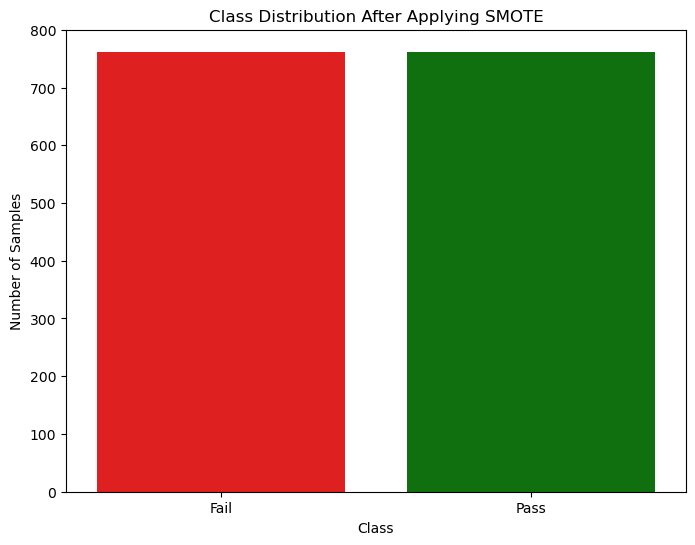

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the balanced class distribution in y_train_balanced
class_counts = pd.Series(y_train_balanced).value_counts()

# Define colors: green for 'pass' (1) and red for 'fail' (0)
colors = ['red' if label == 0 else 'green' for label in class_counts.index]

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
plt.title("Class Distribution After Applying SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks([0, 1], ["Fail", "Pass"])  # Set custom labels for x-axis
plt.show()


In [150]:
# Calculate class weights
class_weights = {0: 1, 1: 10}  # Adjust weights as needed

# Create the model with class weights
lr = LogisticRegression(class_weight=class_weights)
lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 10})

In [151]:
# Retrain the Logistic Regression model
#lr = LogisticRegression(random_state=42)
#lr.fit(X_resampled, y_resampled)

In [152]:
# Predict on the test set
y_pred_lr = lr.predict(X_test)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]  # Probability of failure

In [153]:
from sklearn.metrics import precision_score

In [154]:
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93       282
           1       0.90      1.00      0.95       318

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600

Accuracy: 0.9416666666666667
Precision: 0.9008498583569405


In [155]:
# Review top terms for each class
feature_names = vectorizer.get_feature_names_out()
top_pass_terms = X[y == 1].sum(axis=0).A1.argsort()[-10:][::-1]
top_fail_terms = X[y == 0].sum(axis=0).A1.argsort()[-10:][::-1]
print("Top terms for 'pass':", [feature_names[i] for i in top_pass_terms])
print("Top terms for 'fail':", [feature_names[i] for i in top_fail_terms])

Top terms for 'pass': ['navigate', 'product', 'page', 'click', 'log', 'add', 'account', 'enter', 'login', 'leave']
Top terms for 'fail': ['navigate', 'click', 'form', 'order', 'product', 'checkout', 'page', 'cart', 'remove', 'submit']


In [156]:
# Predict probabilities for the test set
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]  # Probability of failure

In [157]:
# Create a new DataFrame for the test set using the indices
df_test = df.iloc[test_idx].copy()

In [158]:
#df_test['Predicted Label'] = y_pred_lr
df_test['Probability of Failure'] = y_pred_proba_lr

In [159]:
# Sort the test set by the predicted failure probability
df_test_sorted = df_test.sort_values(by='Probability of Failure', ascending=False)

# Display the top priority test cases
df_test_sorted.head()

,ID,Test Scenario,Test Cases,Expected Result,Execution #1,cleaned_test_cases,Probability of Failure
1927,1928,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,0.997193
777,778,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,0.997193
427,428,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,0.997193
727,728,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,0.997193
527,528,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,0.997193


In [160]:
# Instantiate and train the Naive Bayes model
nba = MultinomialNB()
nba.fit(X_train_balanced, y_train_balanced)

MultinomialNB()

In [161]:
# Predict on the test set
y_pred_nb = nba.predict(X_test)
y_pred_proba_nb = nba.predict_proba(X_test)[:, 1]  # Probability

In [162]:
# Display classification report and metrics for Naive Bayes
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       282
           1       0.93      0.91      0.92       318

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600

Accuracy: 0.9116666666666666
Precision: 0.9260450160771704


In [163]:
# Create a new DataFrame for the test set using the indices from train_test_split
df_test_nb = df.iloc[test_idx].copy()
df_test_nb['Predicted Label'] = y_pred_nb
df_test_nb['Probability'] = y_pred_proba_nb

In [164]:
# Sort the test set by the predicted failure probability in descending order
df_test_sorted_nb = df_test_nb.sort_values(by='Probability', ascending=False)

# Display the top priority test cases with the highest failure probability
print("\nTop priority test cases predicted to fail (Naive Bayes):")
df_test_sorted_nb.head()


Top priority test cases predicted to fail (Naive Bayes):


,ID,Test Scenario,Test Cases,Expected Result,Execution #1,cleaned_test_cases,Predicted Label,Probability
427,428,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,1,0.998227
1977,1978,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,1,0.998227
527,528,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,1,0.998227
777,778,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,1,0.998227
1927,1928,Address Management,Log in to account. Navigate to address book. A...,New address is added to the address book.,1,log account navigate address book add new address,1,0.998227


In [165]:
import pickle

# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(nba, file)

# Load the model
#with open('model.pkl', 'rb') as file:
    #loaded_model = pickle.load(file)

In [166]:

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)